Diana Covaci, 261 086 280

Nicholas Milin, 261 106 314

Viktor Allais, 261 148 866

Link to write-up draft: https://docs.google.com/document/d/1SFnJJ0C4B64lkwmnU2XbigqCRX71LE-kLrOZSMkxHWE/edit?usp=sharing 

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!pip install -q numpy pandas matplotlib seaborn scikit-learn ucimlrepo
!pip install -q torchvision gensim
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q pytorch-pretrained-bert transformers
!pip install -q torchinfo

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
from gensim.models import Word2Vec
from collections import Counter
import sys
import random as rn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from pytorch_pretrained_bert import BertModel, BertTokenizer
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, random_split
import save_load_models as slm
from torchinfo import summary

from data_loader import load_data, clean_and_tokenize, get_lstm_loaders, get_bert_loaders

/Users/nicholasmilin/Downloads/McGill/U3/Fall/COMP 551/Assignment 4/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: Acquire and pre-process the Web of Science Dataset

In [ ]:
# load data (text and labels) using the data_loader
X, y1, y2 = load_data("WOS11967")

labels = {0:"Computer Science", 1:"Electrical Engineering", 2:"Psychology", 3:"Mechanical Engineering", 
          4:"Civil Engineering", 5:"Medical Science", 6:"Biochemistry"}

## LSTM Pre-processing

In [20]:
# Preprocessing is handled inside get_lstm_loaders in data_loader.py
# This handles W2V loading/creation, tokenization, and dataset splitting
lstm_train_loader, lstm_val_loader, lstm_test_loader, embedding, vocab_size = get_lstm_loaders()

# Generate tokenized data and word frequency for Data Exploration
tokenized_X_LSTM = [clean_and_tokenize(line) for line in X]
word_frequency = Counter(word for line in tokenized_X_LSTM for word in line)

print(f"LSTM vocab size: {vocab_size}")
print(f"LSTM embedding shape: {embedding.shape}")

Loading data...
Flattened subdomains: found 34 unique (domain, subdomain) pairs.
Loading embeddings from saved_models/embeddings.pkl...
Preprocessing data (tokenization only)...
DataLoaders created: Train (262), Val (57), Test (57)
Loading data...
Flattened subdomains: found 34 unique (domain, subdomain) pairs.
Tokenizing with BERT...
DataLoaders created: Train (262), Val (57), Test (57)
Loading data...
Flattened subdomains: found 34 unique (domain, subdomain) pairs.
Tokenizing with BERT...
BERT DataLoaders created: Train (262), Val (57), Test (57)
BERT DataLoaders created: Train (262), Val (57), Test (57)
LSTM vocab size: 116926
LSTM embedding shape: torch.Size([116926, 100])
LSTM vocab size: 116926
LSTM embedding shape: torch.Size([116926, 100])


## BERT Pre-processing

In [ ]:
# Preprocessing is handled inside get_lstm_loaders in data_loader.py
bert_train_loader, bert_val_loader, bert_test_loader = get_bert_loaders()

# Generate tokenized data and word frequency for Data Exploration
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [21]:
lengths = [
    len(bert_tokenizer(text, add_special_tokens=True)['input_ids']) for text in X
]

print("Average:", np.mean(lengths))
print("90th percentile:", np.percentile(lengths, 90))
print("95th percentile:", np.percentile(lengths, 95))

Average: 271.4757249101696
90th percentile: 415.0
95th percentile: 471.0


## Data Exploration

Number of abstract:  11967
Average size of tokenized abstracts:  195


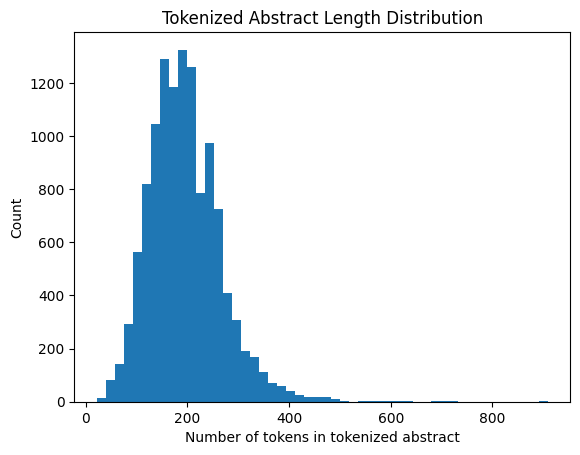

90th percentile: 282.0
95th percentile: 319.0


In [23]:
print("Number of abstract: ", len(tokenized_X_LSTM))

tokenized_lengths = [len(tokens) for tokens in tokenized_X_LSTM]
print("Average size of tokenized abstracts: ", round(sum(tokenized_lengths) / len(tokenized_lengths)))

plt.hist(tokenized_lengths, bins=50)
plt.xlabel("Number of tokens in tokenized abstract")
plt.ylabel("Count")
plt.title("Tokenized Abstract Length Distribution")
plt.show()

print("90th percentile:", np.percentile(tokenized_lengths, 90))
print("95th percentile:", np.percentile(tokenized_lengths, 95))

In [24]:
# explore the vocabulary created in the pre-processing pipeline
top_20 = word_frequency.most_common(20)
print("20 most common:")

for word, count in top_20: 
    print(f"\t{word}: {count}")

least_10 = word_frequency.most_common()[:-11:-1]
print("10 least common:")
for word, count in least_10: 
    print(f"\t{word}: {count}")

20 most common:
	the: 137659
	of: 94404
	and: 83693
	in: 56425
	to: 51202
	a: 42398
	for: 24482
	is: 23694
	with: 22828
	that: 18285
	this: 15408
	on: 15254
	as: 14479
	by: 13685
	are: 13271
	were: 11397
	was: 11316
	we: 10254
	an: 10054
	from: 9392
10 least common:
	georegistration: 1
	self-calibration,: 1
	geo-accurate: 1
	non-a: 1
	anti-amyloid-beta: 1
	crelated: 1
	communitylevel: 1
	dmpp.: 1
	n-related: 1
	non-disruptive: 1


Domain (YL1) class counts: 
 y1
4    2107
2    1959
3    1925
6    1728
5    1617
0    1499
1    1132
Name: count, dtype: int64


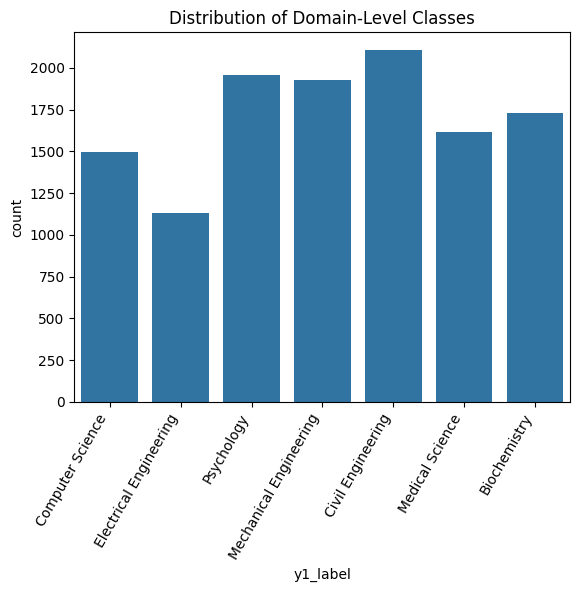

In [25]:
# explore the labels y1 & y2
y_vals = pd.DataFrame({'y1':y1, 'y2':y2})
y_vals['y1_label'] = y_vals['y1'].map(labels)

print("Domain (YL1) class counts: \n", y_vals['y1'].value_counts())

sns.countplot(x='y1_label', data=y_vals, order=list(labels.values()))
plt.xticks(rotation=60, ha='right')
plt.title("Distribution of Domain-Level Classes")
plt.show()

In [ ]:
#bert_model = AutoModel.from_pretrained('bert-base-uncased')

#with torch.no_grad(): 
#    outputs = bert_model(input_ids=encoding['input_ids'], attention_mask=encoding['attention_mask'])
# embeddings = outputs.last_hidden_state
# cls_embeddings = embeddings[:, 0, :]

# Task 2: Implement LSTM and BERT models

### LSTM Models (Hyperparameter Tuning)

Model loaded from saved_models/lstm_subdomain_lr_0.100_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.050_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.010_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.005_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.001_20.pkl


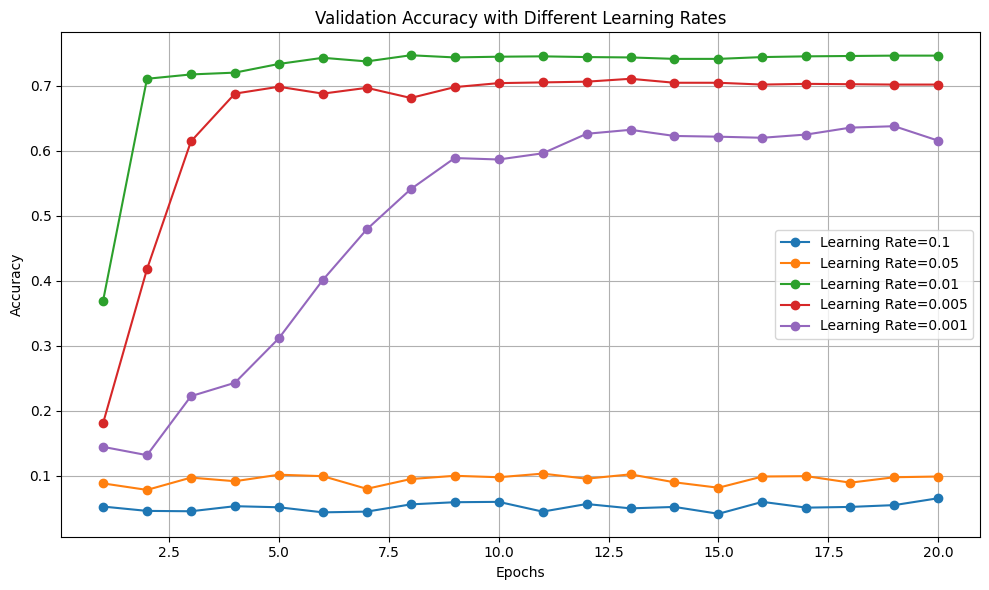

In [34]:
plt.figure(figsize=(10, 6))
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]

for lr in learning_rates:
    model = slm.load_model(f"lstm_subdomain_lr_{lr:.3f}_20.pkl")
    
    if model is None:
        continue
    
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Model loaded from saved_models/lstm_domain_lr_0.100_20.pkl
Model loaded from saved_models/lstm_domain_lr_0.050_20.pkl
Model loaded from saved_models/lstm_domain_lr_0.010_20.pkl
Model loaded from saved_models/lstm_domain_lr_0.005_20.pkl
Model loaded from saved_models/lstm_domain_lr_0.001_20.pkl


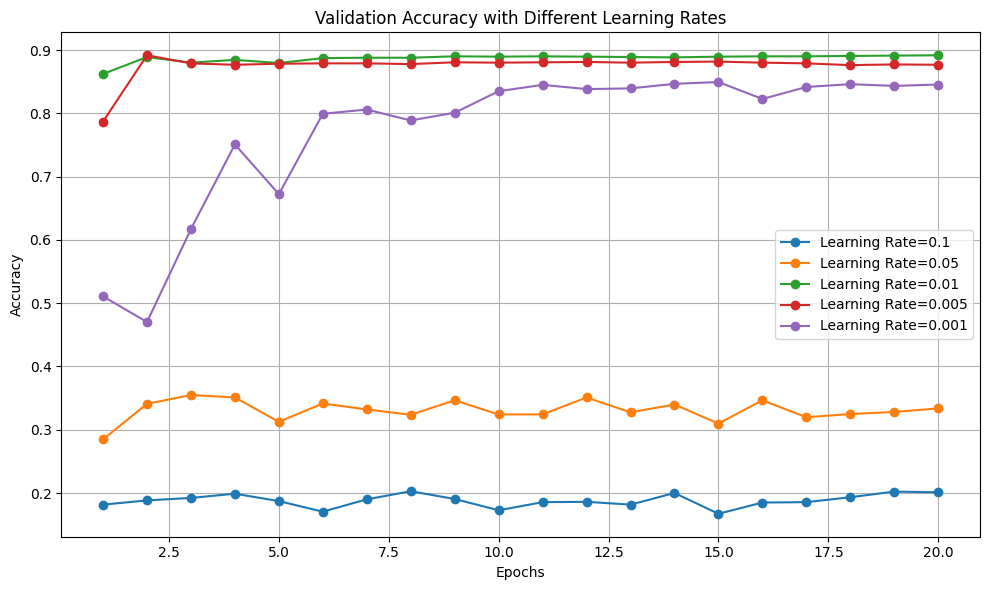

In [27]:
plt.figure(figsize=(10, 6))
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]

for lr in learning_rates:
    model = slm.load_model(f"lstm_domain_lr_{lr:.3f}_20.pkl")
    if model is None:
        continue
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

### BERT Models (Hyperparameter Tuning)

Model loaded from saved_models/bert_subdomain_lr_1e-05.pkl
Model loaded from saved_models/bert_subdomain_lr_2e-05.pkl
Model loaded from saved_models/bert_subdomain_lr_5e-05.pkl


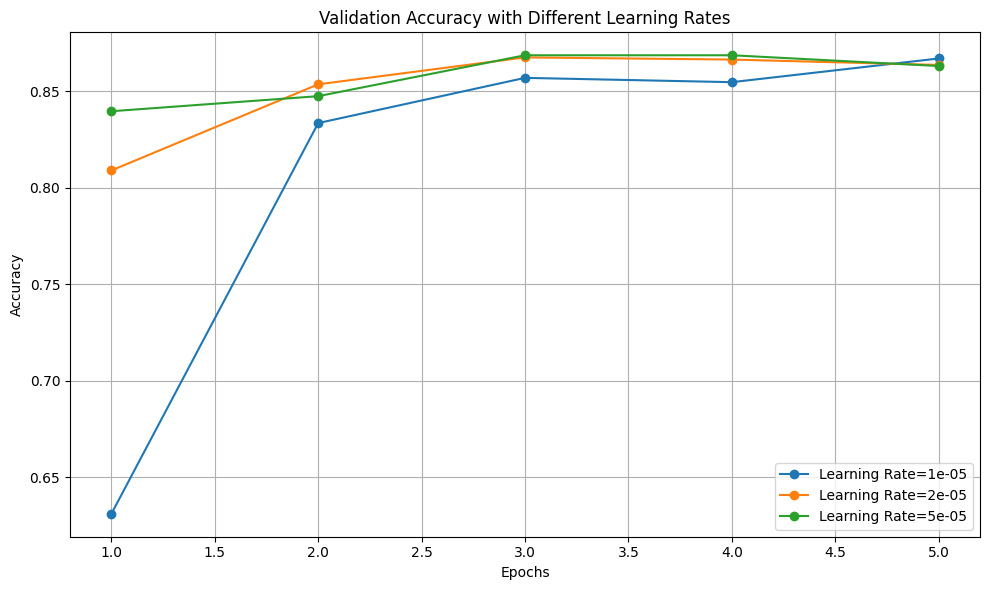

In [10]:
plt.figure(figsize=(10, 6))
learning_rates = [0.00001, 0.00002, 0.00005]

for lr in learning_rates:
    model = slm.load_model(f"bert_subdomain_lr_{lr}.pkl")
    
    if model is None:
        continue
    
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

Model loaded from saved_models/bert_domain_lr_1e-05.pkl
Model loaded from saved_models/bert_domain_lr_2e-05.pkl
Model loaded from saved_models/bert_domain_lr_5e-05.pkl


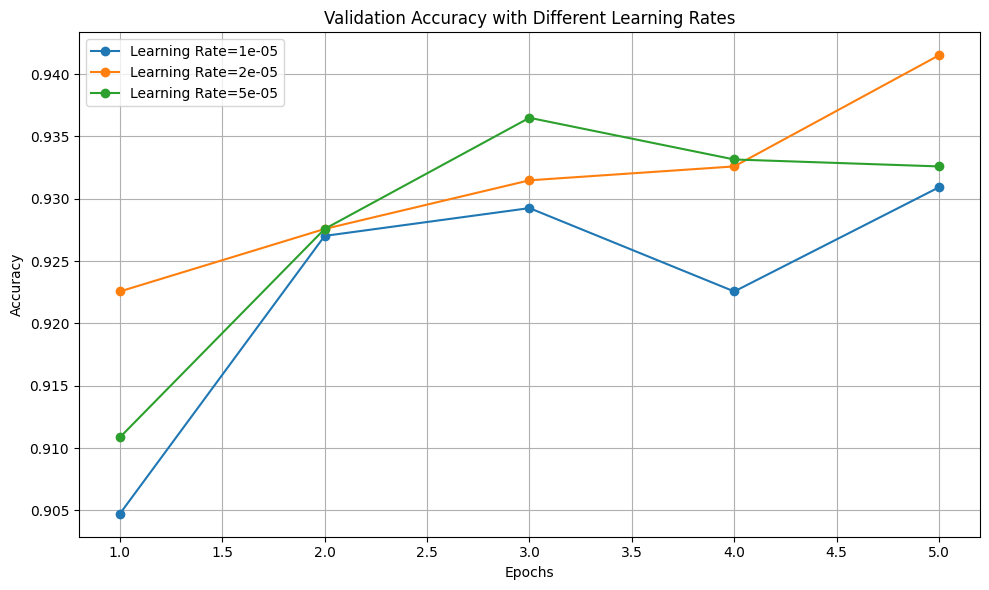

In [11]:
plt.figure(figsize=(10, 6))
learning_rates = [0.00001, 0.00002, 0.00005]

for lr in learning_rates:
    model = slm.load_model(f"bert_domain_lr_{lr}.pkl")
    if model is None:
        continue
    epochs = range(1, len(model.val_losses) + 1)
    summary(model)
    plt.plot(epochs, model.val_accuracies, marker='o', label=f'Learning Rate={lr}')

plt.title('Validation Accuracy with Different Learning Rates')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# Task 3: Running Experiments

### (1) Comparison of the LSTM & BERT Models

In [32]:
LSTM_BEST_LR = 0.01
BERT_DOMAIN_BEST_LR = 0.00001 # change this (after hyperparameter tuning)
BERT_SUBDOMAIN_BEST_LR = 0.00002


lstm_domain = slm.load_model(f"lstm_domain_lr_{LSTM_BEST_LR:.3f}_20.pkl")
lstm_subdomain = slm.load_model(f"lstm_subdomain_lr_{LSTM_BEST_LR:.3f}_20.pkl")

bert_domain = slm.load_model(f"bert_domain_lr_{BERT_DOMAIN_BEST_LR}.pkl")
bert_subdomain = slm.load_model(f"bert_subdomain_lr_{BERT_SUBDOMAIN_BEST_LR}.pkl")

if lstm_domain is None or lstm_subdomain is None or bert_domain is None or bert_subdomain is None:
    raise ValueError("One or more models could not be loaded. Please check the file names and paths.")

results = {
    "Model": ["LSTM", "BERT"],
    "Domain Test Accuracy": [lstm_domain.test_accuracies[-1], bert_domain.test_accuracies[-1]],
    "Subdomain Test Accuracy": [lstm_subdomain.test_accuracies[-1], bert_subdomain.test_accuracies[-1]]
}

print(pd.DataFrame(results))

Model loaded from saved_models/lstm_domain_lr_0.010_20.pkl
Model loaded from saved_models/lstm_subdomain_lr_0.010_20.pkl
Model loaded from saved_models/bert_domain_lr_1e-05.pkl
Model loaded from saved_models/bert_subdomain_lr_2e-05.pkl
  Model  Domain Test Accuracy  Subdomain Test Accuracy
0  LSTM              0.873608                 0.785078
1  BERT              0.926503                 0.875835


### (2) Attention Matrix

#### (a) Words & Class Tokens

In [ ]:
if lstm_domain is None or lstm_subdomain is None or bert_domain is None or bert_subdomain is None:
    raise ValueError("One or more models could not be loaded. Please check the file names and paths.")

# setting our device!
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# arbitrary choice (5 & 5)
transformer_block = 5
attention_head = 5

bert_domain.eval() # is this necessary?

batch = next(iter(bert_test_loader)) # first batch
correctly_predicted_documents = []
incorrectly_predicted_documents = []

# find correctly & incorrectly predicted documents
with torch.no_grad():
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device) # since domain

    outputs = bert_domain(input_ids, attention_mask)
    preds = torch.argmax(outputs.logits, dim=1)

    # iterating through the predictions to find documents
    for i in range(len(preds)):
        document = {
            "input_ids": input_ids[i].unsqueeze(0), # unsqueeze(0) for BERT
            "attention_mask": attention_mask[i].unsqueeze(0),
            "label": labels[i].item(),
            "pred": preds[i].item()
        }

        if preds[i] == labels[i]:
            correctly_predicted_documents.append(document)
        else:
            incorrectly_predicted_documents.append(document)

correctly_predicted_document = correctly_predicted_documents[0]
incorrectly_predicted_document = incorrectly_predicted_documents[0]

with torch.no_grad():
    correct_outputs = bert_domain(
        correctly_predicted_document["input_ids"].to(device),
        correctly_predicted_document["attention_mask"].to(device),
        output_attentions = True
    )

    incorrect_outputs = bert_domain(
        incorrectly_predicted_document["input_ids"].to(device),
        incorrectly_predicted_document["attention_mask"].to(device),
        output_attentions = True
    )

correct_attention_matrix = correct_outputs.attentions[transformer_block][0][attention_head]
incorrect_attention_matrix = incorrect_outputs.attentions[transformer_block][0][attention_head]

CLS_correct = correct_attention_matrix[0].cpu().numpy() # 0: for CLS, might need a .cpu() if on a GPU
CLS_incorrect = incorrect_attention_matrix[0].cpu().numpy() # same here!

correct_tokens = bert_tokenizer.convert_ids_to_tokens(correctly_predicted_document["input_ids"][0].tolist())
incorrect_tokens = bert_tokenizer.convert_ids_to_tokens(incorrectly_predicted_document["input_ids"][0].tolist())

#### (b) Plot the Matrix Between the Words and the Class Tokens

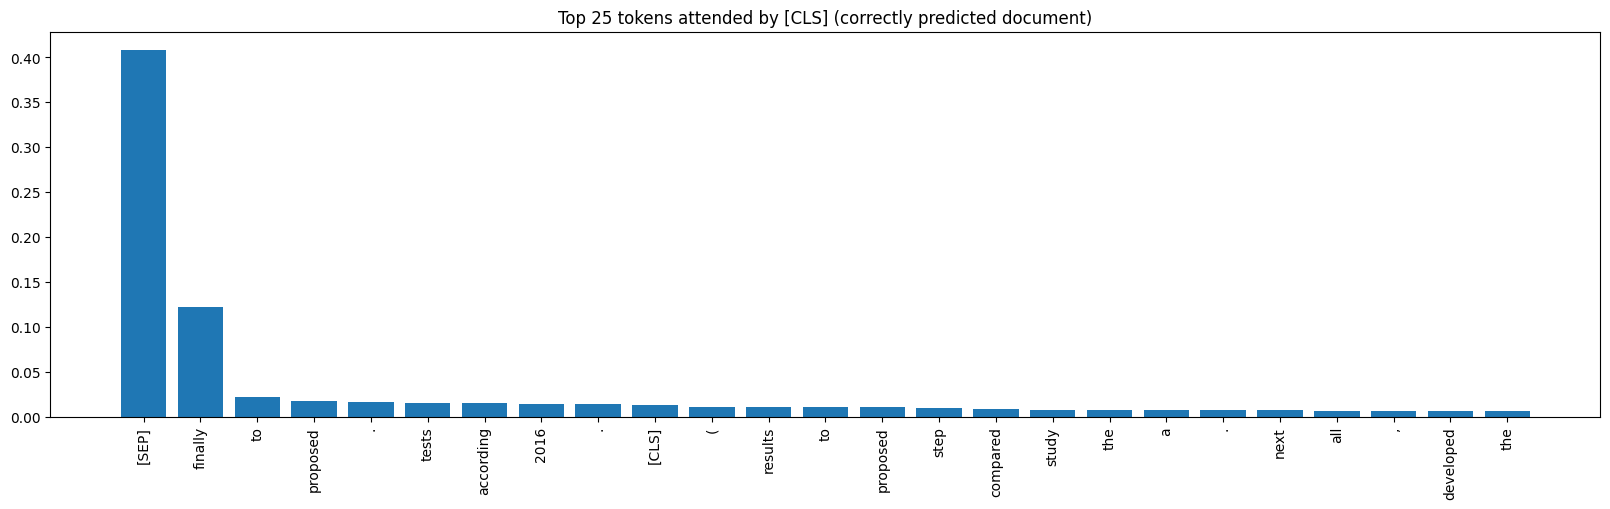

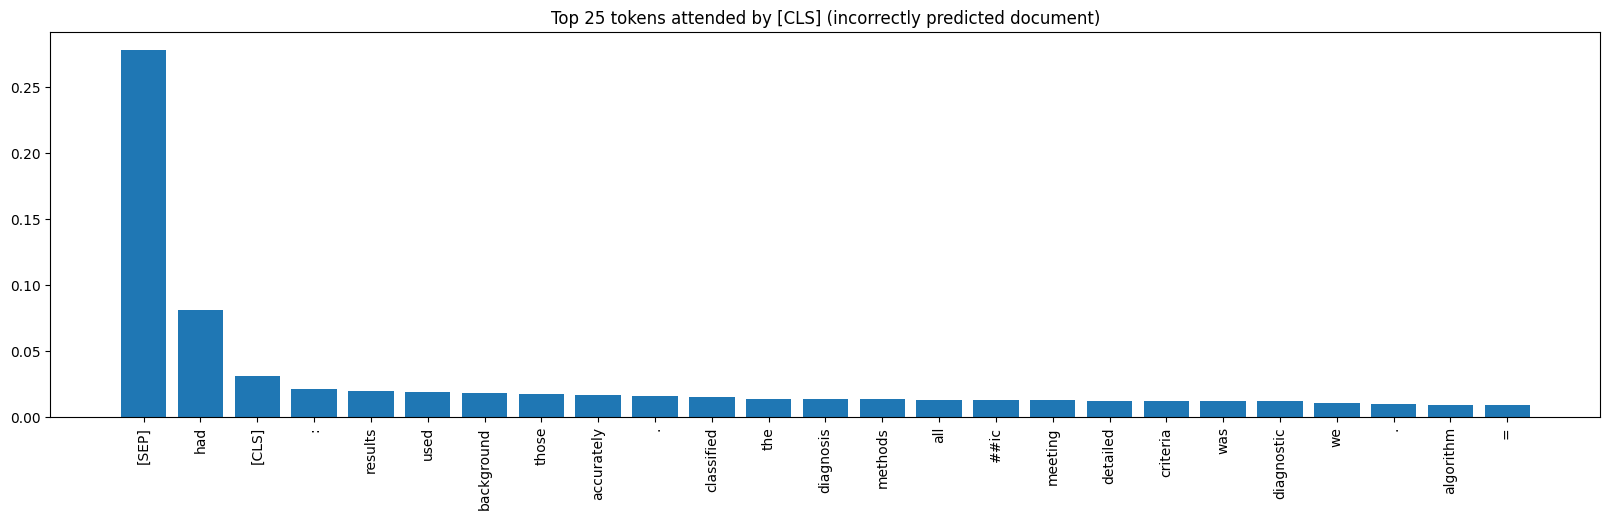

In [31]:
# pair the tokens w/ their corresponding attention weight
correct_pairs = []
for i in range(len(correct_tokens)):
    correct_pairs.append((
        correct_tokens[i], CLS_correct[i]
    ))

incorrect_pairs = []
for i in range(len(incorrect_tokens)):
    incorrect_pairs.append((
        incorrect_tokens[i], CLS_incorrect[i]
    ))

# ascending order
correct_pairs.sort(key = lambda tup: tup[1], reverse=True)
incorrect_pairs.sort(key = lambda tup: tup[1], reverse=True)

# 25 top tokens
top_correct_tokens = [pair[0] for pair in correct_pairs[:25]]
top_correct_weight = [pair[1] for pair in correct_pairs[:25]]

top_incorrect_tokens = [pair[0] for pair in incorrect_pairs[:25]]
top_incorrect_weight = [pair[1] for pair in incorrect_pairs[:25]]

# plot for correctly predicted document
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_correct_tokens)), top_correct_weight)
plt.xticks(range(len(top_correct_tokens)), top_correct_tokens, rotation=90)
plt.title("Top 25 tokens attended by [CLS] (correctly predicted document)")
plt.show()

# plot for incorrectly predicted document
plt.figure(figsize=(20, 5))
plt.bar(range(len(top_incorrect_tokens)), top_incorrect_weight)
plt.xticks(range(len(top_incorrect_tokens)), top_incorrect_tokens, rotation=90)
plt.title("Top 25 tokens attended by [CLS] (incorrectly predicted document)")
plt.show()